In [1]:
import numpy as np
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import umap
import umap.plot as umap_plot
from umap.parametric_umap import ParametricUMAP
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import to_hex
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar

In [2]:
# set dpi for all figures
plt.rcParams['figure.dpi'] = 300

In [3]:
# load preprocessed dataset
raw_data_preprocessed = pd.read_pickle(pathlib.Path(r'..\\data\\processed_data\\raw_data_preprocessed.pkl'))

# Get list of unique indices
indices = raw_data_preprocessed["measurement_data_compensated"].index.get_level_values(0).unique()
# Use groupby to split DataFrame
grouped = raw_data_preprocessed["measurement_data_compensated"].groupby(level=0)
# get fcs data as a list of dataframes of each sample
fcs_data = [grouped.get_group(index).reset_index(drop=True) for index in indices]

# same for labels
indices = raw_data_preprocessed["reported_labels"].index.get_level_values(0).unique()
grouped = raw_data_preprocessed["reported_labels"].groupby(level=0)
labelset = [grouped.get_group(index).reset_index(drop=True) for index in indices]

In [4]:
# create color map for each celltype

categories = ["None", "Lympho", 'BP', 'NKP', 'TP', 'T4P', 'T8P', 'NKTP']

viridis = plt.get_cmap('viridis')
vals = np.linspace(0, 1, len(categories))
[(val, to_hex(viridis(val))) for val in vals]
semi_viridis_hex_colors = [to_hex(viridis(val)) for val in vals]
# # Create a color dictionary
color_dict_hex = {category: i for  category, i  in zip(categories, semi_viridis_hex_colors)}

# Add new entries
color_dict_hex['NKT4P'] = '#fde725'
color_dict_hex['NKT8P'] = '#fde725'
color_dict_hex['BPNKP'] = '#ff0000'

In [5]:
# select subset of data
cell_subsets_of_interst = ['Lympho', 'BP', 'NKP', 'TP', 'T4P', 'T8P']

train_size = 30000 # use most of the data from each FCS file in the training/validation set
valid_size = 1 # dumb one event here to keep the logic already implemented
files_used_for_training_of_classifier = str(train_size) + ' events of each file, from 0 to 50, as a single long list'

x_train = []
x_valid = []
y_train = []
y_valid = []
indices_train = []
indices_valid = []
for i in range(0, 50):
    (x_train_loop, x_valid_loop, 
     y_train_loop, y_valid_loop,
    indices_train_loop, indices_valid_loop) = train_test_split(fcs_data[i], 
                                                               labelset[i][cell_subsets_of_interst],
                                                               labelset[i][cell_subsets_of_interst].index,
                                                               train_size=train_size, test_size=valid_size,
                                                               random_state=42)
    x_train.append(x_train_loop)
    y_train.append(y_train_loop)
    x_valid.append(x_valid_loop)
    y_valid.append(y_valid_loop)
    indices_train.append(indices_train_loop)
    indices_valid.append(indices_valid_loop)

In [6]:
def create_umap_labels(df):
    unique_class_map = {'0-0-0-0-0-0': 0, #'None',
                        '1-0-0-1-1-0': 5, #'T4P',
                        '1-1-0-0-0-0': 2, #'BP',
                        '1-0-1-0-0-0': 3, #'NKP',
                        '1-0-0-1-0-1': 6, #'T8P',
                        '1-0-0-1-0-0': 4, #'TP',
                        '1-0-1-1-1-0': 8, #'NKT4P',
                        '1-0-0-0-0-0': 1, #'Lympho',
                        '1-1-1-0-0-0': 10, #'BPNKP',
                        '1-0-1-1-0-0': 7, #'NKTP',
                        '1-0-1-1-0-1': 9} #'NKT8P'}
    df.loc[:, 'unique_class'] = df.astype(str).agg('-'.join, axis=1).map(unique_class_map)
    return df['unique_class'].to_list()

In [7]:
# create unique labels for umap
y = pd.concat(y_train)
umap_labels = create_umap_labels(y)

In [ ]:
# standard scale features
umap_data = pd.concat(x_train)

umap_scaler = StandardScaler()
umap_data = umap_scaler.fit_transform(umap_data)

joblib.dump(umap_scaler, pathlib.Path(r"scalers\\umap_scaler.save")) 

In [7]:
# define the network
dims = pd.concat(x_train).shape[1:]
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [ ]:
# please note, this might take some time
# to make use of our pre-trained model, skip this line

# pass encoder network to ParametricUMAP
umap_parametric = ParametricUMAP(n_components=2, n_neighbors=25, encoder=encoder, n_epochs=2,
                                batch_size=1000, verbose=False, random_state=0, min_dist=0.1)
umap_fit = umap_parametric.fit(X=umap_data, y=umap_labels)

In [10]:
from umap.parametric_umap import load_ParametricUMAP
import pathlib
umap_fit = load_ParametricUMAP(pathlib.Path(r'saved_models\\seq_nn_parametric_umap'))
umap_scaler = joblib.load(pathlib.Path(r'scalers\\umap_scaler.save'))

Pickle of ParametricUMAP model loaded from saved_models\seq_nn_parametric_umap\model.pkl
Keras encoder model loaded from saved_models\seq_nn_parametric_umap\encoder
Keras full model loaded from saved_models\seq_nn_parametric_umap\parametric_model


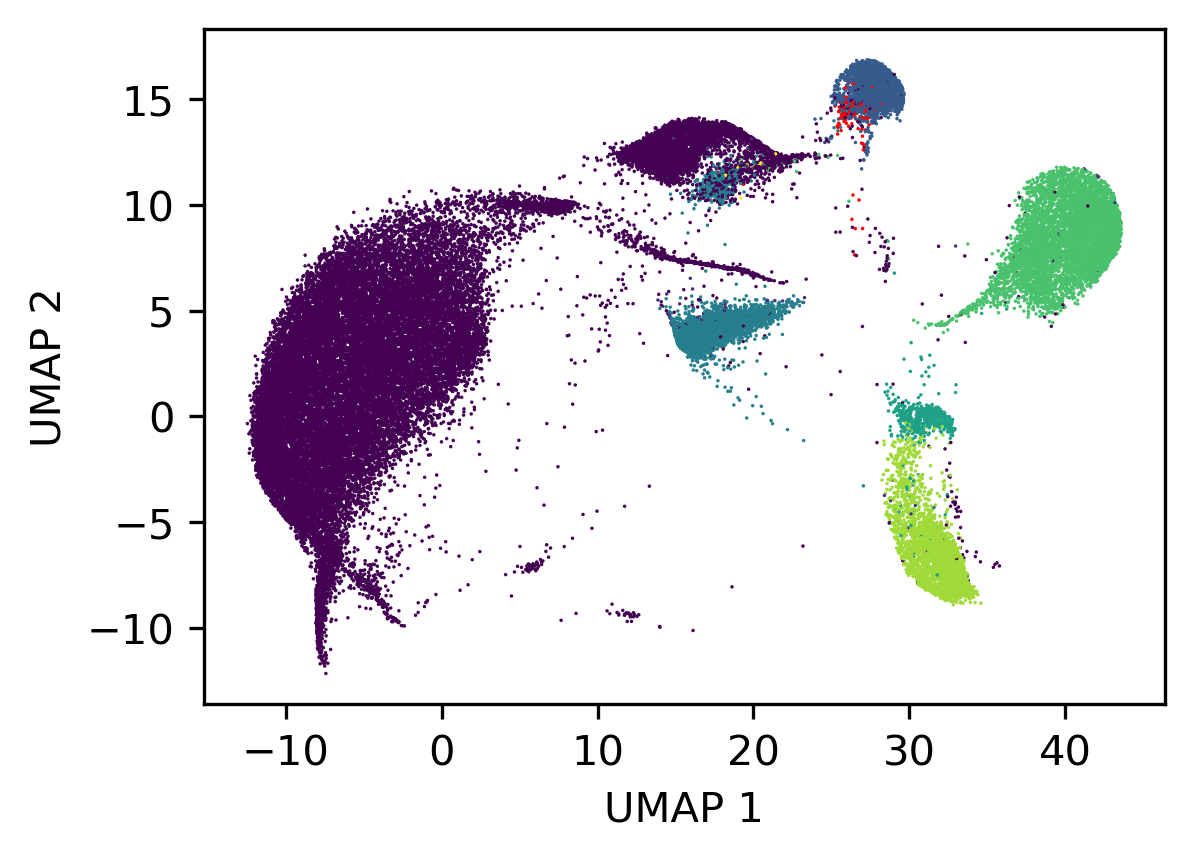

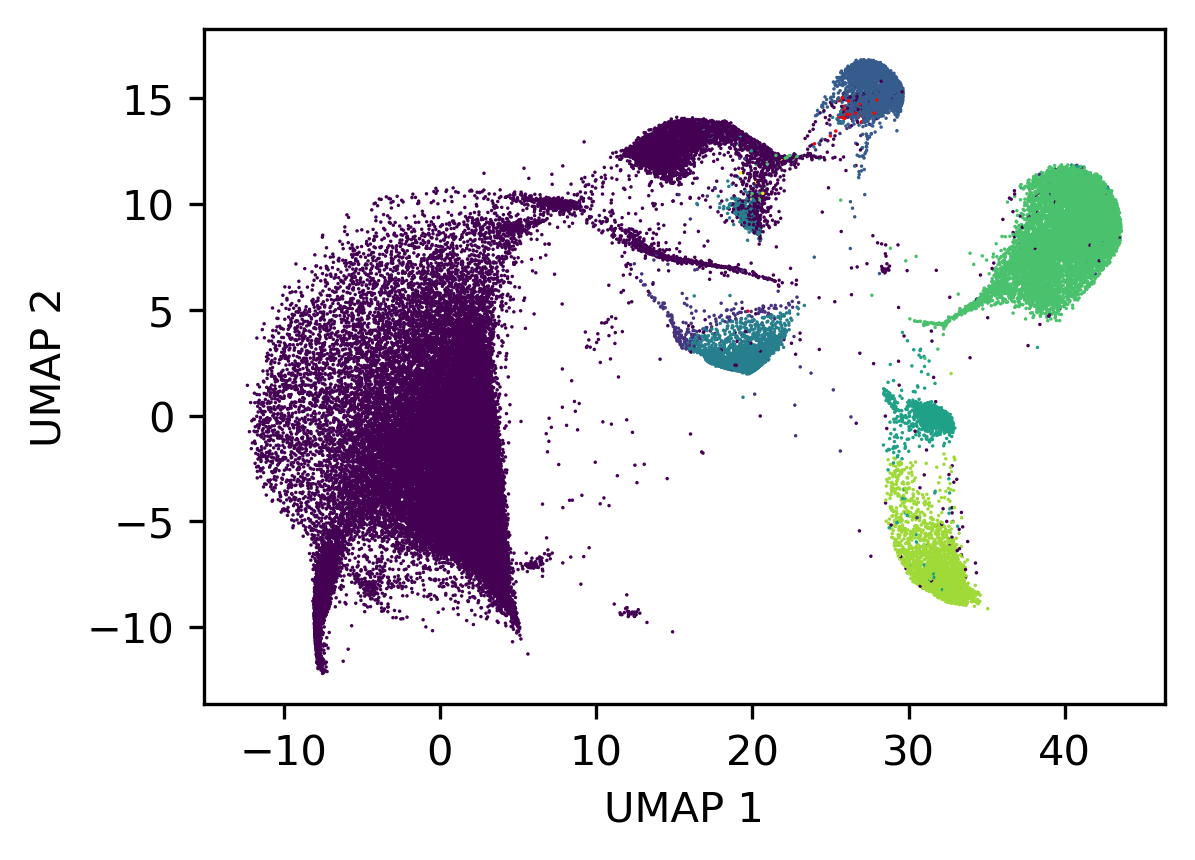

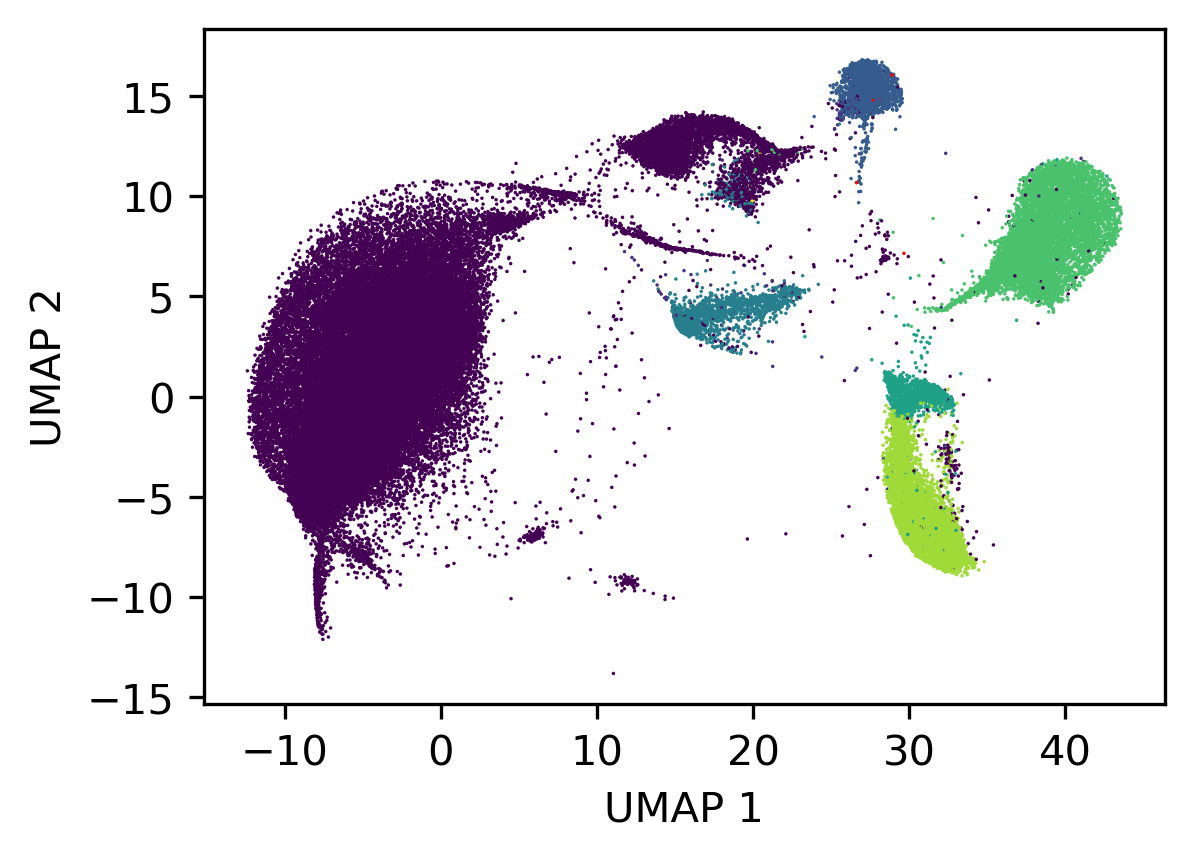

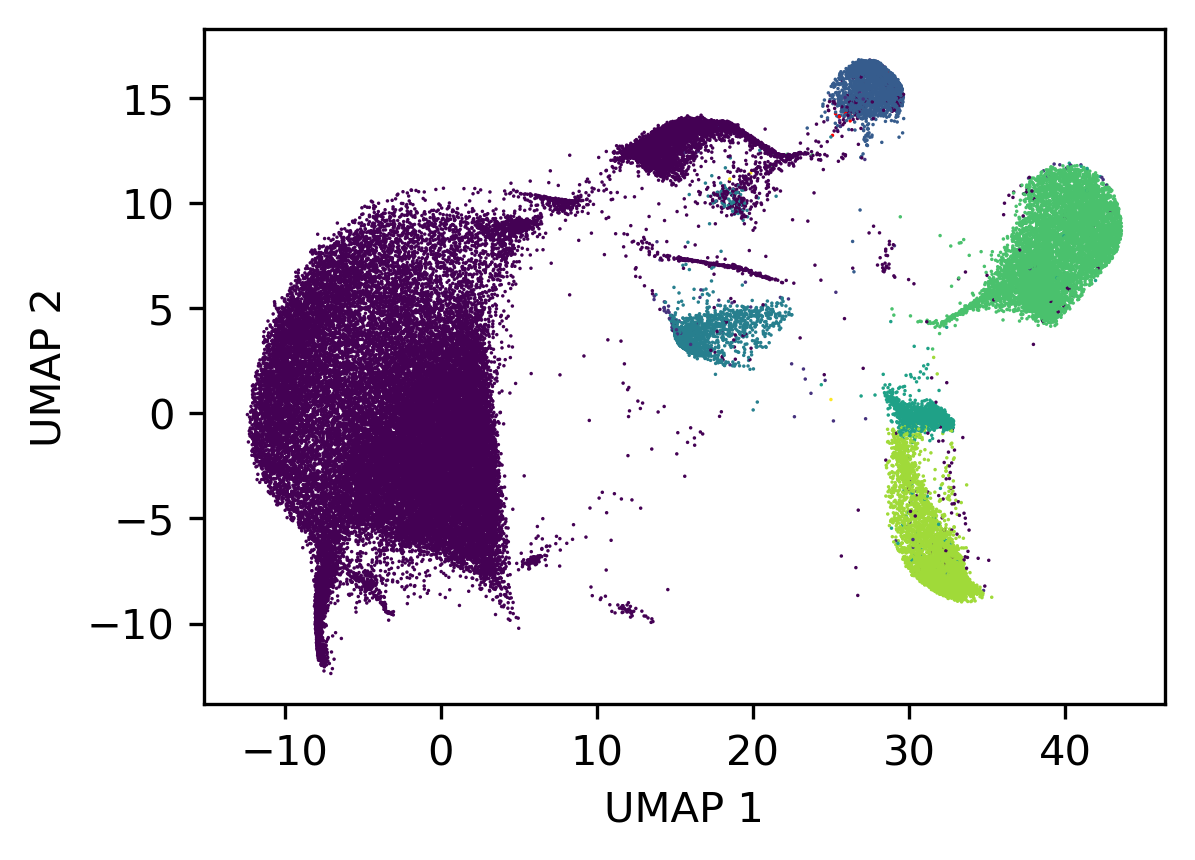

In [11]:
reverse_class_map = {0: 'None',
                     5: 'T4P',
                     2: 'BP',
                     3: 'NKP',
                     6: 'T8P',
                     4: 'TP',
                     8: 'NKT4P',
                     1: 'Lympho',
                     10: 'BPNKP',
                     7: 'NKTP',
                     9: 'NKT8P'}
# Create a colormap from your list of colors
cmap = mcolors.ListedColormap(list(color_dict_hex.values()))

# Create a normalize object the scale the colorbar
norm = mcolors.Normalize(vmin=0, vmax=len(color_dict_hex))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # specify which files should be transformed and visualized
    for i in range(0, 4):
        embedding = umap_fit.transform(umap_scaler.transform(fcs_data[i]))
        labels_umap = create_umap_labels(labelset[i][cell_subsets_of_interst])
        
        cell_type_labels = [reverse_class_map[label] for label in labels_umap]
        color_labels = [color_dict_hex[reverse_class_map[label]] for label in labels_umap]
        
        # Create a figure with two subplots: one for the scatter plot (ax1) and one for the color bar (ax2)
        fig, ax1 = plt.subplots(figsize=(8.27/2, 11.69/4))
        
        scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=color_labels, s=0.7, edgecolors='none')
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')

        plt.show()

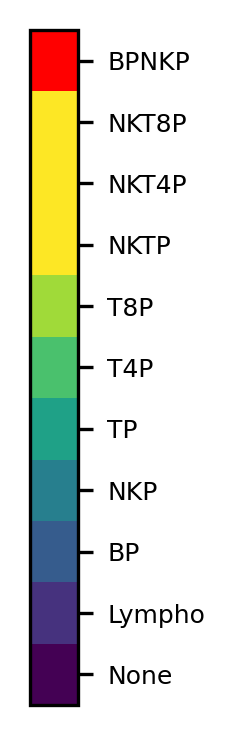

In [43]:
fig, ax = plt.subplots(figsize=(8.27/40, 11.69/4))

# Create color map
cmap = mcolors.ListedColormap(list(color_dict_hex.values()))

norm = mcolors.Normalize(vmin=0, vmax=len(color_dict_hex))

cb1 = mcolorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

# Add labels
cb1.set_ticks(np.arange(0.5, len(color_dict_hex), 1))
cb1.set_ticklabels(list(color_dict_hex.keys()), fontsize=6)

plt.show()

In [201]:
umap_parametric.save('saved_models\\seq_nn_parametric_umap')

INFO:tensorflow:Assets written to: saved_models\seq_nn_parametric_umap\encoder\assets
Keras encoder model saved to saved_models\seq_nn_parametric_umap\encoder
INFO:tensorflow:Assets written to: saved_models\seq_nn_parametric_umap\parametric_model\assets
Keras full model saved to saved_models\seq_nn_parametric_umap\parametric_model
Pickle of ParametricUMAP model saved to saved_models\seq_nn_parametric_umap\model.pkl
